In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import openturns as ot
import openturns.viewer as viewer
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from windrose import WindroseAxes
ot.RandomGenerator.SetSeed(0)

In [3]:
ot.ResourceMap.SetAsUnsignedInteger('KernelSmoothing-BinNumber', 5000)

In [4]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{bm}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [5]:
N = 1000
data = pd.read_csv("./data/wind_waves_ANEMOC_1H.csv", index_col=0)
data = data.iloc[:N]
# usually the convention considers 0° for wind blowing to the north
# the convention adopted by Erik and in farmshadow is different 
# to plot correctly on the wind rose need to define a new wind direction 
data['θ_wind (deg)'] = np.mod(data['θ_wind (deg)'] - 90, 360)
data['θ_wave_new (deg)'] = np.mod(data['θ_wave_new (deg)'] - 90, 360)
sample = ot.Sample(np.array(data.values))
sample.setDescription(data.columns)

In [6]:
data.head()

,θ_wind (deg),U_hub (m/s),θ_wave_new (deg),Hs (m),Tp (s)
119765,290.316179,17.595685,241.676239,5.324022,11.095472
256151,217.765048,16.233226,312.182571,4.276201,11.167593
161153,265.814336,12.091653,264.733376,2.178312,7.481896
279845,303.501723,17.859394,256.428680,2.354004,6.823448
178602,122.981202,15.886104,46.048599,2.653330,6.993559


In [7]:
# usually the convention considers 0° for wind blowing to the north
# the convention adopted by Erik and in farmshadow is different 
# to plot correctly on the wind rose need to define a new wind direction 
sample_wd = sample[:, 0]
sample_ws = sample[:, 1]
sample_wave_dir = sample[:, 2]
sample_Hs = sample[:, 3]
sample_Tp = sample[:, 4]
sample_HT = sample[:,(0,3)]

## Data visualization

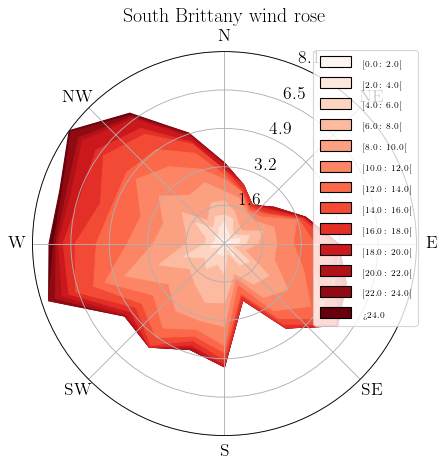

In [8]:
ax = WindroseAxes.from_ax()
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)

ax.contourf(np.array(sample_wd).flatten(), np.array(sample_ws).flatten(), normed=True, bins=np.arange(0, 26, 2), nsector=20, cmap=cm.Reds)
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], fontsize=16)
ax.set_title('South Brittany wind rose', fontsize=18)
ax.set_legend(loc='best', fontsize=14);
fig.savefig('figures/SB_wind_rose.png', bbox_inches='tight', dpi=300, transparent=True)

## Marginal distribution inference

### Wind speed

In [9]:
factory_mle_wbl3 = ot.MaximumLikelihoodFactory(ot.WeibullMin())
# Give bounds for the optimization
lowerBound=[1., 1., 0.0]
upperBound=[15.0, 3.0, 1.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
factory_mle_wbl3.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory_mle_wbl3.getOptimizationAlgorithm()
solver.setStartingPoint([10.0, 2.0, 0.0])
# solve the distribution
fitted_ws = factory_mle_wbl3.build(sample_ws)
print(fitted_ws)

WeibullMin(beta = 11.3928, alpha = 2.21245, gamma = 0)


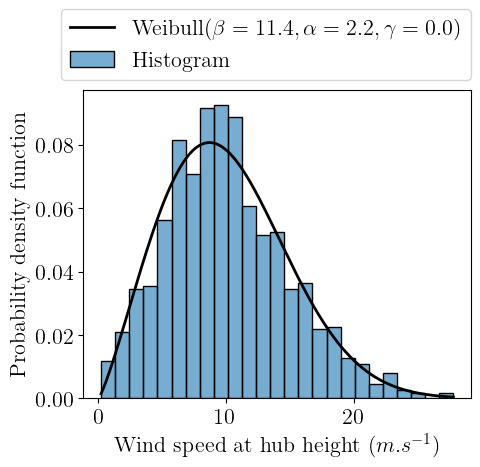

In [10]:
serie = data["U_hub (m/s)"].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = fitted_ws.computePDF(xplot)
params = fitted_ws.getParameter()
#
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Weibull($\\beta={params[0]:.1f}, \\alpha={params[1]:.1f}, \\gamma={params[2]:.1f}$)')
sns.histplot(data=data, x="U_hub (m/s)", bins=25, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Wind speed at hub height ($m.s^{-1}$)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/free_wsp_distribution_SB.png", bbox_inches='tight', dpi=300, transparent=True);

### Wind direction

In [11]:
kernel = ot.KernelSmoothing()
kernel.setBoundaryCorrection(True)
kernel.setLowerBound(0.)
kernel.setUpperBound(360.)
# Different bandwidth computation 
# (see: http://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_estimate_non_parametric_distribution.html)
silverman_kw = kernel.computeSilvermanBandwidth(sample_wd)
mixed_kw = kernel.computeMixedBandwidth(sample_wd)
plugin_kw = kernel.computePluginBandwidth(sample_wd)
print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
wd_kde = kernel.build(sample_wd, mixed_kw)
wd_kde = ot.TruncatedDistribution(wd_kde, 0., 360.)

Silverman bandwidth = 31.01
Mixed bandwidth = 19.08
Plugin bandwidth = 14.97


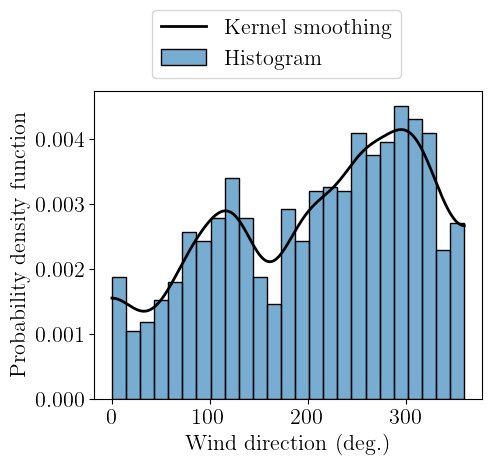

In [12]:
serie = data['θ_wind (deg)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = wd_kde.computePDF(xplot)
#
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Kernel smoothing')
sns.histplot(data=data, x='θ_wind (deg)', bins=25, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Wind direction (deg.)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/wind_dir_distribution_SB.png", bbox_inches='tight', dpi=300, transparent=True);

### Wave direction

In [13]:
kernel = ot.KernelSmoothing()
kernel.setBoundaryCorrection(True)
kernel.setLowerBound(0.)
kernel.setUpperBound(360.)
# Different bandwidth computation 
# (see: http://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_estimate_non_parametric_distribution.html)
silverman_kw = kernel.computeSilvermanBandwidth(sample_wave_dir)
mixed_kw = kernel.computeMixedBandwidth(sample_wave_dir)
plugin_kw = kernel.computePluginBandwidth(sample_wave_dir)
print("Silverman bandwidth = {:.2f}".format(silverman_kw[0]))
print("Mixed bandwidth = {:.2f}".format(mixed_kw[0]))
print("Plugin bandwidth = {:.2f}".format(plugin_kw[0]))
wave_dir_kde = kernel.build(sample_wave_dir, mixed_kw)
wave_dir_kde = ot.TruncatedDistribution(wave_dir_kde, 0., 360.)

Silverman bandwidth = 7.85
Mixed bandwidth = 7.44
Plugin bandwidth = 7.06


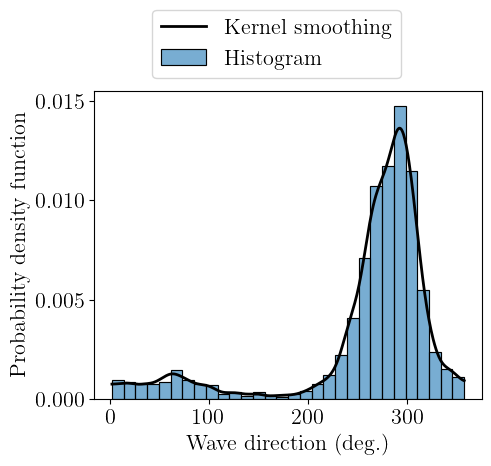

In [14]:
serie = data['θ_wave_new (deg)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = wave_dir_kde.computePDF(xplot)
# Visu
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Kernel smoothing')
sns.histplot(data=data, x='θ_wave_new (deg)', bins=30, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Wave direction (deg.)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/wave_dir_distribution_SB.png", bbox_inches='tight', dpi=300, transparent=True);

### Significant wave height

In [15]:
factory_mle_wbl3_h = ot.MaximumLikelihoodFactory(ot.WeibullMin())
# Give bounds for the optimization
lowerBound=[1.0, 1.0, -1.0]
upperBound=[5.0, 3.0, 1.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
factory_mle_wbl3_h.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory_mle_wbl3_h.getOptimizationAlgorithm()
solver.setStartingPoint([4.0,2.0,0.0])
# solve the distribution
fitted_Hs = factory_mle_wbl3_h.build(sample_Hs)
print(fitted_Hs)

WeibullMin(beta = 2.09919, alpha = 1.48429, gamma = 0.470251)


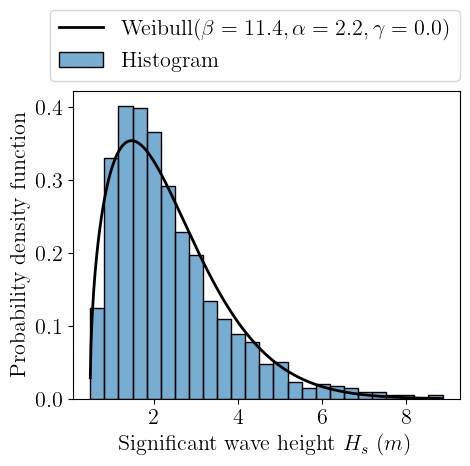

In [16]:
serie = data['Hs (m)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = fitted_Hs.computePDF(xplot)
params = fitted_ws.getParameter()
# Visu
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'Weibull($\\beta={params[0]:.1f}, \\alpha={params[1]:.1f}, \\gamma={params[2]:.1f}$)')
sns.histplot(data=data, x='Hs (m)', bins=25, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Significant wave height $H_s$ ($m$)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/Hs_distribution_SB.png", bbox_inches='tight', dpi=300, transparent=True);

### Wave period

In [17]:
factory = ot.MaximumLikelihoodFactory(ot.InverseNormal())
# Give bounds for the optimization
lowerBound=[7., 140.0]
upperBound=[8., 150.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True], [True,True])
factory.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory.getOptimizationAlgorithm()
solver.setStartingPoint([7.5, 145.])
# solve the distribution
fitted_Tp = factory.build(sample_Tp)
print(fitted_Tp)

InverseNormal(mu = 8, lambda = 140)


WRN - Starting point is not inside bounds x=[1,1] bounds=class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[7,140] upper bound=class=Point name=Unnamed dimension=2 values=[8,150] finite lower bound=[1,1] finite upper bound=[1,1]


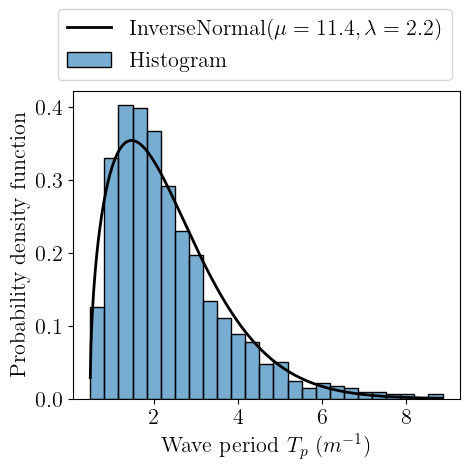

In [18]:
serie = data['Hs (m)'].values
xplot = np.linspace(serie.min(), serie.max(), 500).reshape(-1, 1)
pdf = fitted_Hs.computePDF(xplot)
params = fitted_ws.getParameter()
# Visu
plt.figure(figsize=(5, 4))
plt.plot(xplot, pdf, color='k', linewidth=2., label=f'InverseNormal($\\mu={params[0]:.1f}, \\lambda={params[1]:.1f}$)')
sns.histplot(data=data, x='Hs (m)', bins=25, stat="density", alpha=0.6, label='Histogram')
plt.xlabel('Wave period $T_p$ ($m^{-1}$)')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(0.47, 1.3), loc='upper center', ncol=1, columnspacing=1.2)
plt.savefig("figures/Tp_distribution_SB.png", bbox_inches='tight', dpi=300, transparent=True);

## Copula inference

In [19]:
marginals = [wd_kde, fitted_ws, wave_dir_kde, fitted_Hs, fitted_Tp]
def estimate_hybrid_model(m):
    copula = ot.BernsteinCopulaFactory().build(sample, int(m))
    return ot.ComposedDistribution(marginals, copula)

## Goodness of fit 

In [20]:
m_list = [5, 10, 20, 100, 1000]
ebc_mmd = pd.DataFrame([], columns=m_list, index=np.arange(100))

In [21]:
# Kernel definition
ker_list = [ot.MaternModel([3.], [1.0], 2.5)] * 5
kernel = ot.ProductCovarianceModel(ker_list)
# Compute MMD 
initial_energy = np.array(kernel.discretize(sample)).mean()

for m in ebc_mmd.columns.values: 
    joint_dist = estimate_hybrid_model(m)
    for i in ebc_mmd.index : 
        ot.RandomGenerator.SetSeed(i)
        mc_sample = joint_dist.getSample(1000)
        perturbed_energy = np.array(kernel.discretize(mc_sample)).mean()
        cross_energy = np.array(kernel.computeCrossCovariance(sample, mc_sample)).mean()
        biaised_mmd2 = initial_energy + perturbed_energy - 2 * cross_energy
        ebc_mmd.loc[i, m] = biaised_mmd2
ebc_mmd

WRN - Warning! The description of the distribution ComposedDistribution is [v0,U_hub (m/s),v0,Hs (m),Tp (s)] and cannot identify uniquely the marginal distribution. Use default description instead.


,5,10,20,100,1000
0,0.002366,0.002293,0.002206,0.002154,0.002055
1,0.002328,0.002212,0.002217,0.002179,0.002054
2,0.002288,0.002246,0.00219,0.002153,0.002032
3,0.002328,0.002265,0.002178,0.002158,0.002088
4,0.002339,0.002268,0.00222,0.002158,0.002051
...,...,...,...,...,...
95,0.002308,0.002218,0.002225,0.002113,0.002031
96,0.002327,0.002241,0.002179,0.002123,0.00203
97,0.002319,0.002231,0.002196,0.002129,0.002023
98,0.002324,0.002245,0.0022,0.002114,0.002072


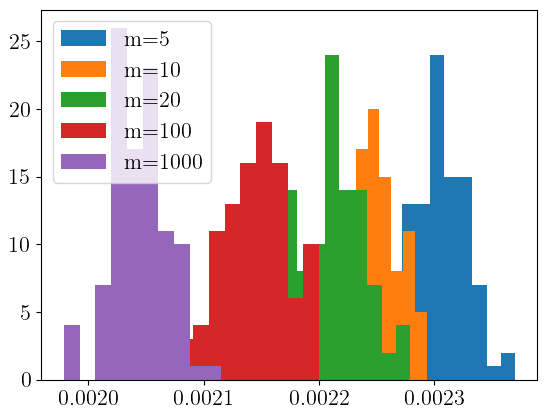

In [22]:
for m in m_list:
    plt.hist(ebc_mmd[m], bins=10, label=f'm={m}')
plt.legend()